In [1]:
# code aangepast van https://www.philschmid.de/bert-text-classification-in-a-different-language
!ipython kernel install --user --name DataLabDisc
!which jupyter
!pip list

Installed kernelspec DataLabDisc in /data/milenadeswart/.local/share/jupyter/kernels/datalabdisc
/data/anaconda3/bin/jupyter
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Package                            Version
---------------------------------- -----------
absl-py                            2.1.0
aiohttp                            3.8.6
aiosignal                          1.3.1
alabaster                          0.7.12
alembic                            1.6.5
altair                             5.0.1
anaconda-client                    1.7.2
anaconda-navigator                 1.9.7
anaconda-project                   0.8.3
appdirs                            1.4.4
asn1crypto                         1.0.1
astroid                            2.3.1
astropy                            3.2.2
astunparse                         1.6.3
async-generator          

In [106]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics as metrics
from scipy.special import expit
import seaborn as sns
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import torch
import pyarrow
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import ClassificationArgs
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

seed = 9

In [3]:
# check device waarop de code runt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [4]:
# gebruik pretrained model (cased!): https://huggingface.co/GroNLP/bert-base-dutch-cased
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stre

In [ ]:
# inladen & mergen data
def merge_annotated_data(naam_dataset, n_annotators, n_annotations = 3):
    """ functie die de gesplitste data gesplitst door split_annotated_data weer kan samenvoegen.
    De datasets met de naam naam_dataset_n_annotators.csv worden ingeladen. Vervolgens wordt de oorspronkelijke dataset gereconstrueerd
    uit de ingeladen data. De oorspronkelijke zinnen en het overzicht van de labels wordt gereturned.

    Input:
    naam_dataset: str, de naam van de documenen die de annotators hebben ingevuld
    n_annotators: int, het aantal annotators
    n_annotations: int, het aantal annotations per zin. default 3

    Output:
    merged_data: een DataFrame met daarin de oorspronkelijke data en de n_annotations labels die zijn toegekend.
    """
    # inladen path naar data en creëren lege frames
    dataset_path = "~/Projecten/programma-discriminatie-en-racisme/datasets/Datasets_2/"
    merged_data = pd.DataFrame()

    for i in range(n_annotators):
        # inladen annotated documenten en samenvoegen
        annotated_doc = pd.read_excel(dataset_path + naam_dataset + "_" + str(i) + '.xlsx')
        annotated_doc = annotated_doc.dropna(subset=['Label', 'text', 'Column1'])
        print(len(annotated_doc))
        columns = list(annotated_doc.columns)

        #display(annotated_doc)

        # document opstellen
        if i == 0:
            merged_data = annotated_doc
        else:
            merged_data = pd.concat([merged_data, annotated_doc])
    
    extra_zoekwoorden = pd.read_excel(dataset_path + 'te_verwijderen.xlsx')
    merged_data = pd.concat([merged_data, extra_zoekwoorden])
    
    missende_zoekwoorden = pd.read_excel(dataset_path + 'missing_words.xlsx')
    merged_data = pd.concat([merged_data, missende_zoekwoorden])
    
    extra_migratie = pd.read_excel(dataset_path + 'extra_migrate.xlsx')
    merged_data = pd.concat([merged_data, extra_migratie])
    
    herlabelled = pd.read_excel(dataset_path + 'herlabellen.xlsx')
    merged_data = pd.concat([merged_data, herlabelled])
    
    #display(merged_data)

    aggregated_data = merged_data.groupby(['Column1']).agg({'id': 'last', 'titel': 'last', 'text': 'last', 'zin': 'last', 'word': 'last', 'Label': 'last'})
    
    print(len(merged_data), len(aggregated_data)) 
    
    #aggregated_data = aggregated_data.sort_values(by = ['Column1'])

    return pd.DataFrame(merged_data), pd.DataFrame(aggregated_data)

merged, aggregated = merge_annotated_data('te_labellen', n_annotators = 8, n_annotations = 3)

display(merged)

In [ ]:
# bekijken dataset
print(merged.columns)

pos = len(aggregated[aggregated.Label == 1.0])
neg = len(aggregated[aggregated.Label==0.0])
unclear = len(aggregated[aggregated.Label==4.0])
useless = len(aggregated[aggregated.Label==7.0])

print(f"The dataset has {pos} biased and {neg} unbiased instances for a total of {pos+neg}. There are {unclear} unclear labels and {useless} useless instances.")

In [ ]:
zoekwoorden_set = set(merged['word'])

print(len(zoekwoorden_set))

zoekwoorden = ['meerbloed', 'hij of zij', 'rolstoelgebonden', 'Andere achtergrond', 'westers', 'mbo-leerling', 'slaven', 'berber', 'joods', 'zwarte school', 'grensoverschrijdend gedrag', 'halfbloed', 'gekleurd', 'hij/zij', 'ontwikkelingslanden', 'plusklassen', 'doventolk', 'probleembuurt', 'zittenblijven', 'zwart', 'lager opgeleid', 'minderheden', 'handicap', 'blank', 'kaukasisch', 'juf ', 'begeleider', 'mohammedaan', 'gebarentolk', 'etnisch', 'bruin', 'thuiszitter', 'stroom', 'derde wereld', 'privilege', 'islam ', 'fobie', 'dubbelbloed', 'stromen', 'non-binair', 'inheems', 'ras', 'excellente school', 'speciaal onderwijs', 'gouden eeuw', 'transseksueel', 'man', 'page', 'rolstoeler', 'ontdekken', 'anderstalig', 'opstromen', 'caribisch gebied', 'gehandicapt', 'rolstoelrijder', 'slavernijverleden', 'hoogopgeleid', 'travestiet', 'tussenpositie', 'witte school', 'slaaf', 'mavo', 'racisme', 'hoofddoek', 'jongen', 'achterstandsscore', 'turk', 'ontdekking', 'medicijnman', 'bediende', 'zigeuner', 'nieuwkomer', 'afstromen', 'arabisch', 'macht', 'exotisch', 'islamiet', 'eskimo', 'oostblok', 'laag opgeleid', 'transgender', 'geslacht', 'armoede', 'lagelonenlanden', 'bi-cultureel', 'verliefd', 'probleemkinderen', 'mbo-cursist', 'ouders', 'hermafrodiet', 'probleemwijk', 'achterstandsschool', 'primitief', 'praktisch geschoold', 'christen', 'mbo-deelnemer', 'dames en heren', 'kloof', 'vluchtelingencrisis', 'achterstandsleerling', 'nieuwe nederlander', 'indiaan', 'queer', 'autochtoon', 'theoretisch geschoold', 'donker', 'meisje', 'allochtoon', 'bicultureel', 'hetero', 'west', 'homo', 'laagopgeleid', 'vrouw', 'seksueel', 'traditie', 'passend onderwijs', 'migranten', 'dwerg', 'achterstandsscholen']
zoekwoorden = set(zoekwoorden)

afwezig = zoekwoorden - zoekwoorden_set
print(len(afwezig))

print(afwezig)

In [ ]:
dataset_path = "~/Projecten/programma-discriminatie-en-racisme/datasets/"
zoekwoorden = pd.read_excel(dataset_path + "Zoekwoorden15.03.24.xlsx", names = ['Categorie', 'Zoekwoord', 'Doel', 'Voorkeur', 'Vermijden', 'Toelichting'])

search_dict = dict(zip(zoekwoorden['Zoekwoord'], zoekwoorden['Categorie']))
#print(search_dict)

# leuk grafiekje van hoe vaak woorden voorkomen
word_freq = {}
i = 0

for woord in merged['word']:
    category = search_dict[woord]
    
    if category in word_freq:
        word_freq[category] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[category] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Word')
plt.title('Frequency of search word categories in dataset')
plt.show()

print(word_freq)

In [227]:
# implementeer undersampling, oversampling, normaal sampling
def sampling_strategy(input_frame, strategy = 'normal', max = 1.0, balance = 0.5):
    if strategy == 'oversampling': # F1 = 0.78
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        output_frame = pd.concat([pos, pos, neg]) # double the sample of positive instances
        
    elif strategy == 'undersampling': # F1 = 0.80
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        max_len = int(max*len(neg))
        output_frame = pd.concat([pos, neg[0:max_len]])
        
    elif strategy == 'balanced': # F1 =
        # len(input_frame) = len(output_frame)
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        neg_len = int(len(input_frame) * balance)
        pos_extra_len = len(input_frame) - neg_len - len(pos)
        output_frame = pd.concat([pos, neg[0:neg_len]])
        
        while pos_extra_len/len(pos) > 1:
            output_frame = pd.concat([output_frame, pos]) # heel extra frame toevoegen
            pos_extra_len -= len(pos)
            
        # anders: overig toevoegen
        output_frame = pd.concat([output_frame, pos[0:pos_extra_len]])
    
    else: #strategy = 'normal' # F1 = 0.78
        output_frame = input_frame[input_frame.label < 2.0] # behoudt alleen labels 0 en 1
    return output_frame

In [228]:
print(len(aggregated))

# prepareer dataset voor inladen in model
model_data = aggregated[aggregated.Label < 2.0]
#model_data = sampling_strategy(aggregated, strategy = 'undersampling', max = 0.7)
display(model_data)

model_data = model_data.drop(columns = ['id', 'titel', 'zin'])
model_data = model_data.rename(columns={"Label": "label", 'text': 'text'}) # totaalscore/label = doel, text = ingelezen tekst

# split dataset: 60% train, 20% val, 20% test
train_val_df, test_df_words = train_test_split(model_data, test_size=0.20, stratify = model_data['label'], random_state=seed)
train_df_words, val_df_words = train_test_split(train_val_df, test_size=0.25, stratify = train_val_df['label'], random_state=seed)

train_df_words = sampling_strategy(train_df_words, strategy = 'oversampling')

train_df = train_df_words.drop(columns = ['word'])
val_df = val_df_words.drop(columns = ['word'])
test_df = test_df_words.drop(columns = ['word'])

print(len(train_df), len(val_df), len(test_df))
print(len(val_df[val_df['label']==1.0]))

4679


,id,titel,text,zin,word,Label
Column1,,,,,,
38,81da7a4b-29e5-44e3-b462-00428735270c,Wijziging van Boek 7 van het Burgerlijk Wetboe...,door tegelijkertijd voor werkgevers de verschi...,6,stromen,0.0
50,4f2497a6-1b5f-4a9c-b30e-00cd3d7cb3c7,Goedkeuring van het voornemen tot opzegging va...,de regering is zich zeer bewust van de nederla...,3,traditie,0.0
53,c2ef8e51-9249-4959-a745-00ce9e84b5e8,"Voorstel van wet van de leden Van der Graaf, J...",dienovereenkomstig streeft elke partij ernaar ...,24,stromen,0.0
110,e8aa1cd5-42a5-49c6-abd6-0124493a0edc,"Voorstel van wet van de leden Bergkamp, Özütok...",tweede kamer der staten-generaal 2 vergaderjaa...,1,hetero,0.0
112,e8aa1cd5-42a5-49c6-abd6-0124493a0edc,"Voorstel van wet van de leden Bergkamp, Özütok...",b in de beweegreden wordt «hetero- of homoseks...,3,hetero,0.0
...,...,...,...,...,...,...
9870,304fdfcb-c3e7-4373-ad19-482bf732d147,Wijziging van de Wet op het hoger onderwijs en...,ten aanzien van studenten die tijdelijk een an...,7,stromen,0.0
9874,304fdfcb-c3e7-4373-ad19-482bf732d147,Wijziging van de Wet op het hoger onderwijs en...,een functiestoornis is een langdurige of blijv...,21,fobie,1.0
9910,314097a8-6eb5-4d89-99e4-485cbfbe552a,Wijziging van enkele belastingwetten en enige ...,een prejudiciële procedure is daarmee niet all...,19,macht,0.0


2714 727 727
179


In [231]:
zoekwoorden_set = set(test_df_words['word'])

print(len(zoekwoorden_set))

zoekwoorden = set(merged['word'])

afwezig = zoekwoorden - zoekwoorden_set
print(len(afwezig))
print(afwezig)

42
4
{nan, 'achterstandsleerling', 'verliefd', 'oostblok'}


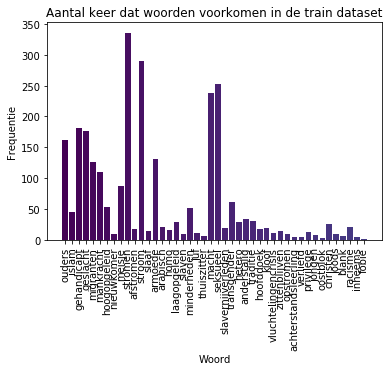

{'ouders': 162, 'islam': 45, 'gehandicapt': 181, 'geslacht': 176, 'migranten': 126, 'mankracht': 110, 'hoogopgeleid': 53, 'nieuwkomer': 10, 'meisje': 87, 'stromen': 336, 'afstromen': 18, 'stroom': 290, 'slaaf': 14, 'armoede': 131, 'arabisch': 21, 'homo': 15, 'laagopgeleid': 28, 'slaven': 10, 'minderheden': 52, 'juf': 11, 'thuiszitter': 6, 'macht': 238, 'seksueel': 252, 'slavernijverleden': 19, 'transgender': 61, 'hetero': 28, 'anderstalig': 34, 'traditie': 30, 'hoofddoek': 17, 'kloof': 19, 'vluchtelingencrisis': 11, 'zittenblijven': 14, 'opstromen': 10, 'achterstandsleerling': 4, 'verliefd': 5, 'privilege': 12, 'jongen': 8, 'oostblok': 2, 'christen': 25, 'joods': 10, 'blank': 6, 'racisme': 21, 'inheems': 5, 'fobie': 1}


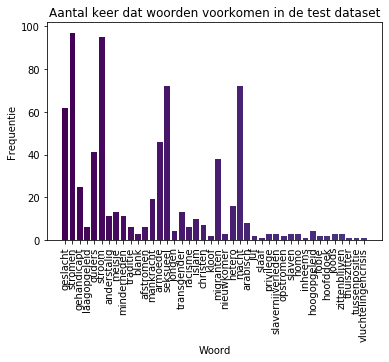

{'geslacht': 62, 'stromen': 97, 'gehandicapt': 25, 'laagopgeleid': 6, 'ouders': 41, 'stroom': 95, 'anderstalig': 11, 'meisje': 13, 'minderheden': 11, 'traditie': 6, 'blank': 3, 'afstromen': 6, 'mankracht': 19, 'armoede': 46, 'seksueel': 72, 'jongen': 4, 'transgender': 13, 'racisme': 6, 'islam': 10, 'christen': 7, 'kloof': 2, 'migranten': 38, 'nieuwkomer': 3, 'hetero': 16, 'macht': 72, 'arabisch': 8, 'juf': 2, 'slaaf': 1, 'privilege': 3, 'slavernijverleden': 3, 'opstromen': 2, 'slaven': 3, 'homo': 3, 'inheems': 1, 'hoogopgeleid': 4, 'fobie': 2, 'hoofddoek': 2, 'joods': 3, 'zittenblijven': 3, 'thuiszitter': 1, 'tussenpositie': 1, 'vluchtelingencrisis': 1}


In [229]:
# hoe vaak zitten woorden in de train set?
word_freq = {}

for woord in train_df_words['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de train dataset')
plt.show()

print(word_freq)

# en in de test set?
word_freq = {}

for woord in test_df_words['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de test dataset')
plt.show()

print(word_freq)

In [298]:
# define hyperparameters
# to change parameters: zie https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
train_args ={"reprocess_input_data": True, # tokenization gebeurt binnen model
             "fp16":False, # vorm van de input van de data
             "silent": False, # zeker weten dat progress bars worden geprint
             "use_multiprocessing": False, # versnelt training
             "use_multiprocessing_for_evaluation": False, # versnelt training
             "overwrite_output_dir": True, # niet ieder model opslaan
             "save_total_limit": 2, # slaat meest recente en beste epoch op
             "save_strategy": 'no', # niet tussentijds opslaan
             "load_best_model_at_end": True, # het beste model inladen
             "num_train_epochs": 7, # hoeveel epochs
             "learning_rate": 0.000002, # learning rate
             "weight_decay": 0.15,
             "optimizer": 'AdamW',
             #"loss_type": "custom",
             #"hidden_dropout_prob": 0.5,
             "evaluate_during_training": True, # om validation data in te laten
            "evaluation_strategy":"epoch", # slaat een tussentijds model op om te evalueren
            #"eval_steps": 2000, # hoe vaak het model wordt opgeslagen
            "train_batch_size": 4, # batch size trainingsdata
            "eval_batch_size": 4} # batch size validation data

model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.fp16 = False
model_args.silent = False
model_args.use_multiprocessing = False
model_args.use_multiprocessing_for_evaluation = False
model_args.overwrite_output_dir = True
model_args.save_total_limit = 2
model_args.save_strategy = "no"
model_args.load_best_model_at_end = True
model_args.num_train_epochs = 4
model_args.learning_rate = 0.000002
model_args.optimizer = "AdamW"
model_args.relative_step = True
model_args.warmup_init = True
model_args.evaluation_during_training = True
model_args.evaluation_strategy = "epoch"
model_args.hidden_dropout_prob = 0.5
model_args.train_batch_size = 8
model_args.eval_batch_size = 8
model_args.no_cache = False
#model_args.loss_type = 'focal'
#model_args.weight_decay = 0.1

# Create a ClassificationModel (code uit bron; zie bovenaan notebook)
model = ClassificationModel(
    "bert", "GroNLP/bert-base-dutch-cased", # Nederlands!!
    #"bert", "bert-base-uncased", # English!!
    num_labels=2, # hoeveel mogelijke targets er zijn
    args=train_args,
    use_cuda=False # omdat dit op de cpu draait
)

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight

In [299]:
# trainen!
train_results = model.train_model(train_df = train_df, eval_df = val_df)

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/679 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/679 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/679 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/679 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/679 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/679 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/679 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [300]:
# testen
from sklearn.metrics import f1_score, accuracy_score

# om f1 te kunnen genereren
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


Running Evaluation:   0%|          | 0/182 [00:00<?, ?it/s]

In [ ]:
# resultaten: mcc = , tp = true positives, tn = true negatives, fp = false negatives, fn = false negatives
print(result)

# 0.7806059741456883, lr = 0.00002, batch = 8, oversampling
# 0.7618282264590501, lr = 0.002, batch = 8, oversampling
# 0.80, lr = default, batch = 8, undersampling
# 0.7892210553443721, lr = 0.00002, batch = 24, oversampling
# 0.7727849196570864, lr = 0.00002, batch = 24, balanced sampling
# 0.7643486483807626, lr = 0.00002, batch = 24, undersampling
# 0.7721387757070184, lr = 0.0002, batch = 24, undersampling
# 0.7656888451873702, lr = default, batch = 8, undersampling
# 0.7819736575481258, batch = 24, epochs = 8, oversampling (doubled)
# 0.7618978588149389, hidden dropout of 0.5, balanced sampling
# 0.7750330201139665, dropout 0.8, balanced sampling
# 0.7470579808026853, category = oversampling
# 0.7551529031388926, dropout 0.5, batch size = 4
# 0.7599348682562457, weight decay = 0.01
# 0.68260712156061, lr = 0.000002, weight decay = 0.1, batch = 8
# 0.6687961596234598, lr = 0.000002, weight decay = 0
# 0.7672738336177362, lr = 0.00002, weight decay = 0.1, batch = 24
# 0.7565585210545067, epochs = 8, weight decay = 0.2
# 0.7620034919249236, epochs = 8, batch = 8, weight decay = 0.2
# 0.758152920054916, epochs = 16
# 0.7524879530693485, epochs = 7, weight decay = 0.15
# , batch size = 4

In [ ]:
# maak een plotje van de loss
print(train_results)

train_losses = train_results[1]['train_loss']
eval_losses = train_results[1]['eval_loss']

plt.plot(train_losses, c = 'teal', label = 'train loss')
plt.plot(eval_losses, c = 'deeppink', label = 'val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and evaluation loss over time')
plt.show()

In [16]:
print(model_outputs)

probabilities = expit(model_outputs) # dit is de sigmoid van de voorspelling
print(probabilities)

[[ 2.03758216 -2.35322595]
 [ 3.1558075  -4.14925909]
 [-2.12877727  2.4454608 ]
 ...
 [ 2.99353552 -3.3284359 ]
 [-1.45371222  1.68145931]
 [ 2.65058756 -3.34778738]]
[[0.88468684 0.0868097 ]
 [0.95913694 0.01553108]
 [0.10633113 0.92022887]
 ...
 [0.95228123 0.03460845]
 [0.18943091 0.84309767]
 [0.9340472  0.03396769]]


In [296]:
#print(list(test_df['text']))

predictions, raw_outputs = model.predict(list(test_df['text']))


  0%|          | 0/46 [00:00<?, ?it/s]

In [18]:
print(predictions)
print(list(test_df['label']))

[0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0
 0 0 1 0 0 0 0 0 1 0 0 0 

0.553072625698324 0.8467153284671532 0.15328467153284672 0.44692737430167595
99 464 84 80


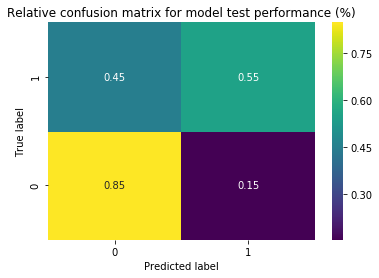

In [297]:
# confusion matrix
tp = result['tp']
tn = result['tn']
fp = result['fp']
fn = result['fn']
total = tp+tn+fp+fn

tp_rel = tp/(tp+fn)
tn_rel = tn/(tn+fp)
fp_rel = fp/(tn+fp)
fn_rel = fn/(tp+fn)

print(tp_rel, tn_rel, fp_rel, fn_rel)
print(tp, tn, fp, fn)

cm = np.array([[tn_rel, fp_rel], [fn_rel, tp_rel]])
ax = sns.heatmap(cm, annot = True, cmap = "viridis")
ax.set_ylim([0,2])
plt.title("Relative confusion matrix for model test performance (%)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

[[0.11531316 0.9131903 ]
 [0.04086306 0.98446892]
 [0.89366887 0.07977113]
 ...
 [0.04771877 0.96539155]
 [0.81056909 0.15690233]
 [0.0659528  0.96603231]]


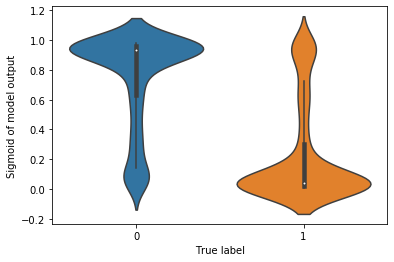

In [282]:
# TO DO: FINISH THIS
# uncertainty of model (violinplot)
print(1-probabilities)

sns.violinplot(data = probabilities)
plt.ylabel("Sigmoid of model output")
plt.xlabel("True label")
plt.show()

{'geslacht': 0.7258064516129032, 'stromen': 0.8969072164948454, 'gehandicapt': 0.92, 'laagopgeleid': 0.8333333333333334, 'ouders': 0.7073170731707317, 'stroom': 0.9789473684210527, 'anderstalig': 1.0, 'meisje': 0.6923076923076923, 'minderheden': 0.7272727272727273, 'traditie': 0.8333333333333334, 'blank': 1.0, 'afstromen': 0.6666666666666666, 'mankracht': 0.9473684210526315, 'armoede': 0.8260869565217391, 'seksueel': 0.9583333333333334, 'jongen': 0.25, 'transgender': 0.3076923076923077, 'racisme': 1.0, 'islam': 0.5, 'christen': 0.8571428571428571, 'kloof': 0.5, 'migranten': 0.5526315789473685, 'nieuwkomer': 0.6666666666666666, 'hetero': 0.8125, 'macht': 0.8888888888888888, 'arabisch': 0.75, 'juf': 0.5, 'slaaf': 1.0, 'privilege': 1.0, 'slavernijverleden': 1.0, 'opstromen': 1.0, 'slaven': 0.6666666666666666, 'homo': 1.0, 'inheems': 1.0, 'hoogopgeleid': 1.0, 'fobie': 0.5, 'hoofddoek': 1.0, 'joods': 0.6666666666666666, 'zittenblijven': 1.0, 'thuiszitter': 1.0, 'tussenpositie': 1.0, 'vlucht

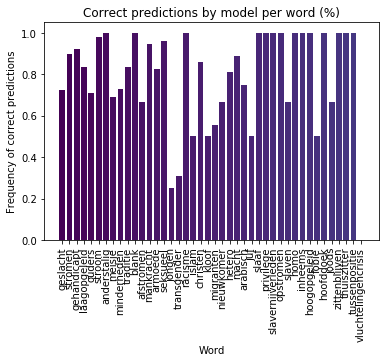

In [284]:
# kijken naar betrouwbaarheid per zoekwoord
test_df_words['predicted'] = predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(test_df_words)):
    woord = test_df_words['word'].iloc[i]
    label = test_df_words['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = mycmap)
#plt.bar(dict_label_relative.keys(), dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per word (%)')
plt.show()

# TODO: TOEVOEGEN HOE VEEL VAN DE WOORDEN EEN 1 ZIJN

{'geslacht': 0.7258064516129032, 'stromen': 0.8969072164948454, 'gehandicapt': 0.92, 'laagopgeleid': 0.8333333333333334, 'ouders': 0.7073170731707317, 'stroom': 0.9789473684210527, 'anderstalig': 1.0, 'meisje': 0.6923076923076923, 'minderheden': 0.7272727272727273, 'traditie': 0.8333333333333334, 'blank': 1.0, 'afstromen': 0.6666666666666666, 'mankracht': 0.9473684210526315, 'armoede': 0.8260869565217391, 'seksueel': 0.9583333333333334, 'jongen': 0.25, 'transgender': 0.3076923076923077, 'racisme': 1.0, 'islam': 0.5, 'christen': 0.8571428571428571, 'kloof': 0.5, 'migranten': 0.5526315789473685, 'nieuwkomer': 0.6666666666666666, 'hetero': 0.8125, 'macht': 0.8888888888888888, 'arabisch': 0.75, 'juf': 0.5, 'slaaf': 1.0, 'privilege': 1.0, 'slavernijverleden': 1.0, 'opstromen': 1.0, 'slaven': 0.6666666666666666, 'homo': 1.0, 'inheems': 1.0, 'hoogopgeleid': 1.0, 'fobie': 0.5, 'hoofddoek': 1.0, 'joods': 0.6666666666666666, 'zittenblijven': 1.0, 'thuiszitter': 1.0, 'tussenpositie': 1.0, 'vlucht

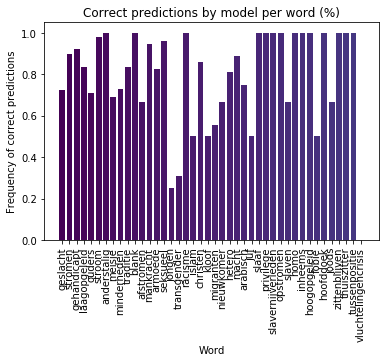

In [253]:
# kijken naar betrouwbaarheid per categorie
test_df_words['predicted'] = predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(test_df_words)):
    woord = test_df_words['word'].iloc[i]
    label = test_df_words['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)
print(dict_label_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = mycmap)
#plt.bar(r+width, dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per word (%)')

plt.show()

# TODO: TOEVOEGEN HOE VEEL VAN DE WOORDEN EEN 1 ZIJN

In [22]:
import numpy as np
import lime
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

class_names = ['positive','negative']

def predictor(texts):
    outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits).detach().numpy()
    return probas

text = 'Building more bypasses will help the environment by reducing pollution and traffic jams in towns and cities.'
print(tokenizer(text, return_tensors='pt', padding=True))

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, predictor, num_features=20, num_samples=2000)
exp.show_in_notebook(text=text)

{'input_ids': tensor([[    1,  1521, 15800,   117, 10031, 27707,   117,   131, 22482,   124,
         13177, 20049, 11281, 29448, 28236, 27106, 10031, 18070, 29167, 26208,
         17586, 29265,  8470, 20271, 25262,   115, 13912,   125,   131, 13644,
         20125,   135,   126,   131,  8470, 10156, 28999,    13,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


TypeError: 'ClassificationModel' object is not callable

In [ ]:
# OUDE/ANDERE CODE

In [ ]:
#dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
#dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'})
print(dataset.columns)


X = list(dataset_zoek["text"])
y = list(dataset_zoek["totaalscore"])
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [ ]:
#tokenized_train = tokenizer(dataset['train']["text"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
#tokenized_data = dict(tokenized_train)
                     
#labels_train = np.array(dataset['train']["label"])  # Label is already an array of 0 and 1)

In [ ]:
# trainen
# sla training_arguments op
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    reprocess_input_data= True,
    fp16=False,
    overwrite_output_dir = True
)

metric = evaluate.load("accuracy")

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
# train model!
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=val,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
# maak dataset correcte format: [{'label': value, 'text': text}, {'label': value, 'text': text}]
data = []

for i in range(len(dataset_zoek)):
    label = dataset_zoek['totaalscore'].iloc[i]
    text = dataset_zoek['zin'].iloc[i]
    tokenized_text = tokenizer(str(text), return_tensors="np", padding=True)
    duo = {'label': label, 'text': tokenized_text}
    data.append(duo)
    
print(len(data))

In [ ]:
# split dataset: 60% train, 20% val, 20% test
trainval, test = train_test_split(data, train_size = 0.8)
train, val = train_test_split(trainval, train_size = 0.75)

print(len(train), len(val), len(test))

In [ ]:
train_labels = []

for item in train:
    train_labels.append(item['label'])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

# Read data
dataset_zoek = pd.read_csv(dataset_path + 'dataset_dummy.csv', sep = ',') # model is te groot om te trainen met volledige dataset zonder GPU
dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'})

# Define pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(dataset_zoek["text"])
y = list(dataset_zoek["totaalscore"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)



In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
# ----- 3. Predict -----#
# Load test data
test_data = pd.read_csv("test.csv")
X_test = list(test_data["review"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
model_path = "output/checkpoint-50000"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
ds = Dataset.from_pandas(dataset)

print(ds)

# split dataset: 60% train, 20% val, 20% test
train_testvalid = ds.train_test_split(test_size=0.4)
# Split the 40% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

print(ds['train']['text'][100])

In [ ]:
def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=True,
        tokenizer=None, 
        topic=None, 
        freeze_bert = None, 
        num_feats=None, 
        keep_stopwords = None,
        combined_feats = None, 
        sum_layers = None
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

       
        combined_feats=aggregate_features(outputs, tokenizer, input_ids, topic, 
                                     num_feats, keep_stopwords, sum_layers).to(device)
        combined_feats = self.dropout(combined_feats)
        logits = self.classifier(combined_feats)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )